In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,RandomizedSearchCV
from xgboost import XGBClassifier
from rfpimp import *
from sklearn.metrics import f1_score,classification_report,confusion_matrix,roc_auc_score
from tqdm import tqdm
import lightgbm as lgb
from sklearn.metrics import f1_score
import ppscore as pps
import seaborn as sns

/home/arya/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
df_sub = pd.read_excel('sample_submission.xlsx')

In [8]:
df_train['labels'].value_counts(normalize=True)

0    0.883007
1    0.116993
Name: labels, dtype: float64

Dataset is Highly Imbalanced need to use a boosting model, but first lets do some EDA To see what the variables
say.

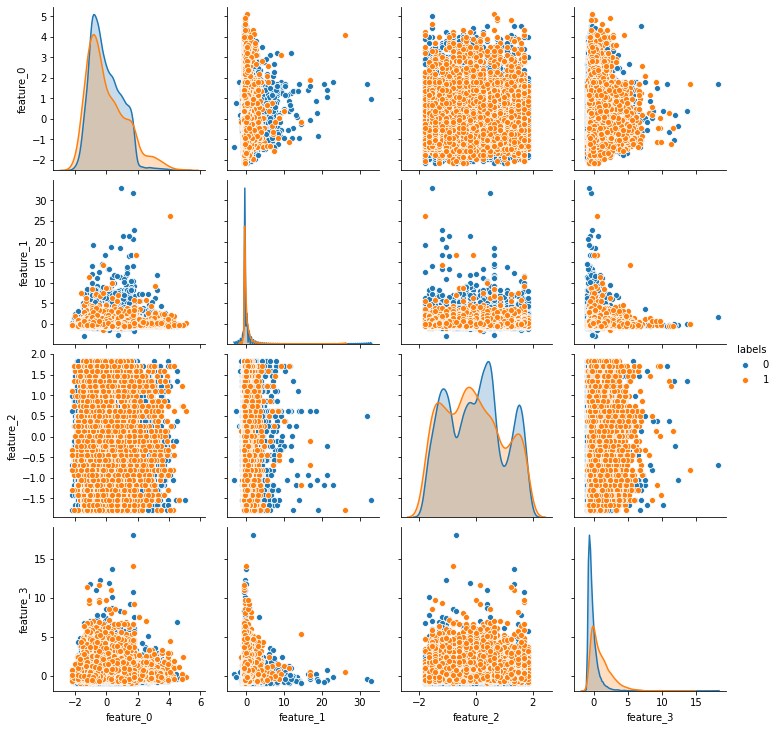

In [14]:
sns.pairplot(data=df_train[['feature_0','feature_1','feature_2','feature_3','labels']],hue='labels',diag_kind='kde')

Seems like feature_1 is not that important it isn't helping us very much,similary will check for all the variables

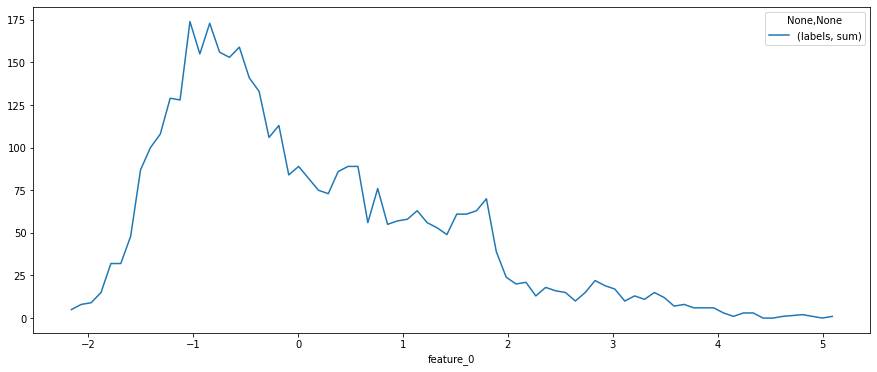

In [19]:
df_train.groupby('feature_0').agg({'labels':[sum]}).plot(figsize=(15,6))

feature_0 seems to be all over the place and doesn't really show any patterns to why labels should be what they should be , similarly will check for other Features

In [109]:
to_drop = ['feature_1','feature_10','feature_6','feature_0','feature_12','feature_7','feature_9','feature_4','feature_8']

Now Using A baseline model and Feature Importances we will see which features gets us the a good cross validation score, the features are mentioned as above which need to be dropped

In [281]:
cv = StratifiedKFold(n_splits=10,random_state=22,shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
score_avg = []
for (train, test), i in zip(cv.split(df_train, y), range(10)):
    m = lgb.LGBMClassifier(n_jobs=-1,random_state=22,scale_pos_weight=3,learning_rate=0.1,n_estimators=100,
                       colsample_bytree=0.5,num_leaves=70,min_child_samples=20,lambda_l1=1.6,lambda_l2=4) 
    m.fit(df_train.drop(to_drop).iloc[train], y.iloc[train])
    score_avg.append(f1_score(y_pred=m.predict(df_train.drop(to_drop).iloc[test]),y_true=y.iloc[test]))
print(pd.DataFrame(data=score_avg))
print(sum(score_avg)/len(score_avg))

          0
0  0.641026
1  0.640167
2  0.625523
3  0.649351
4  0.638342
5  0.616025
6  0.658037
7  0.655172
8  0.649269
9  0.628812
0.6401723789231413


The lgbm model above with 10 folds give us a nice score of 64.027 on the Leaderboard seems like model is not overfitting,I also trained a XGBboost model with 5 folds which give a Score of 63.813 on Leaderboard, now we will combine both the models see the improvements

In [279]:
from sklearn.externals import joblib
model = joblib.load('xgb_model.pkl')

/home/arya/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [508]:
preds_xgb = model.predict_proba(df_test.drop(to_drop,axis=1))
preds_lgb = m.predict_proba(df_test.drop(to_drop,axis=1))

Here I m predicting probabilites and using two models I m getting a score of 64.831 on Leaderboard, using weighted ensembling

In [509]:
df_sub['labels'] = preds_xgb[:,1]*0.4 + preds_lgb[:,1]*0.6

In [510]:
df_sub['labels'] = df_sub['labels'].apply(lambda x: 1 if x>0.5 else 0)

In [460]:
df_sub.to_excel('First_sub.xlsx',index=False)